# Importing Libraries
The base functionality of Python is limited, but the use of packages make it really easy. Here is a chunk of code to load some external libraries:

- numpy: essentially the mathematical tools of MATLAB
- mpmath: high precision mathematics
- scipy: good numerical science package for python with some special functions and optimizations
- matplotlib: AMAZING library for plotting. the gold standard of python

In [3]:
import numpy as np
import mpmath as mp 
from scipy.optimize import fsolve
from scipy.special import gammainc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.interpolate as interpolate
from statistics import mean
import pandas as pd
import seaborn as sns

# Mass Radius Homology Relation:

The relation I find is:

$R = 0.88212826928M^{0.20520031}$ when $M < 20M_\odot$ and



$R = 0.32523391725M^{0.55009911}$ when $M > 20M_\odot$ 

where M is in units of solar masses and R is in units of solar radii

In [55]:
print(low)
print(high)
r_low = (10**(low[1]))*mfit_low**(low[0])
r_high = (10**(high[1]))*mfit_high**(high[0])

[ 0.20520031 -0.05446826]
[ 0.55009911 -0.48780417]


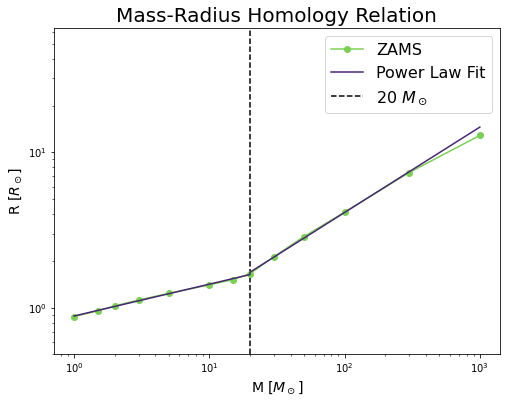

In [53]:
#constants
Lsun       = 3.846e33
LeddFactor = 3.7142e4

#load the data
M = [1, 1.5, 2, 3, 5, 10, 15, 20, 30, 50, 100, 300, 1000]
R = np.power(10,[-0.0581, -0.0203, 0.0108, 0.0487, 0.0911, 0.1462, 0.1803, 0.2183, 0.3270, 0.4570, 0.6147, 0.8697, 1.1090])

# fit power law
low  = np.polyfit(np.log10(M[0:8]),np.log10(R[0:8]),1)
high = np.polyfit(np.log10(M[7:-1]),np.log10(R[7:-1]),1)
mfit_low = np.logspace(0, np.log10(20), 25)
mfit_high = np.logspace(np.log10(20), 3, 25)
r_low = (10**(low[1]))*mfit_low**(low[0])
r_high = (10**(high[1]))*mfit_high**(high[0])
mfit = np.concatenate((mfit_low, mfit_high))
r_fit = np.concatenate((r_low,r_high))


palette = plt.get_cmap('viridis')
plt.figure(figsize = (8,6))
plt.loglog(M,R, 'o-', color = palette(0.8), label = 'ZAMS')
plt.loglog(mfit, r_fit, color = palette(0.1), label = 'Power Law Fit')
plt.vlines(x = 20, ymin = 0, ymax = 10e2, label = '20 $M_\odot$', ls = 'dashed')
plt.ylim((0.5, 10**1.8))
plt.title('Mass-Radius Homology Relation', fontsize = 20)
plt.xlabel('M [$M_\odot$]', fontsize = 14)
plt.ylabel('R [$R_\odot$]', fontsize = 14)
plt.legend(fontsize = 16)
plt.show()

#  ZAMS fit

This is a plot of the fit for the zero-age main sequence star luminosity. The numerical form is:

$\Large{L_{n u c} \simeq 10^{\frac{\log \left(3.7142 \times 10^{4} L_{\odot} s / \text { erg }\right)}{1+\exp (-0.8502 x-1.9551)} \cdot x^{\frac{2.0135}{x^{0.4817}+1}} \operatorname{erg} / \mathrm{s}}}$

where $x \equiv \frac{M_\star}{M_\odot}$ and $L_\odot = 3.846 \times 10^{33} \operatorname{erg} / \mathrm{s}$

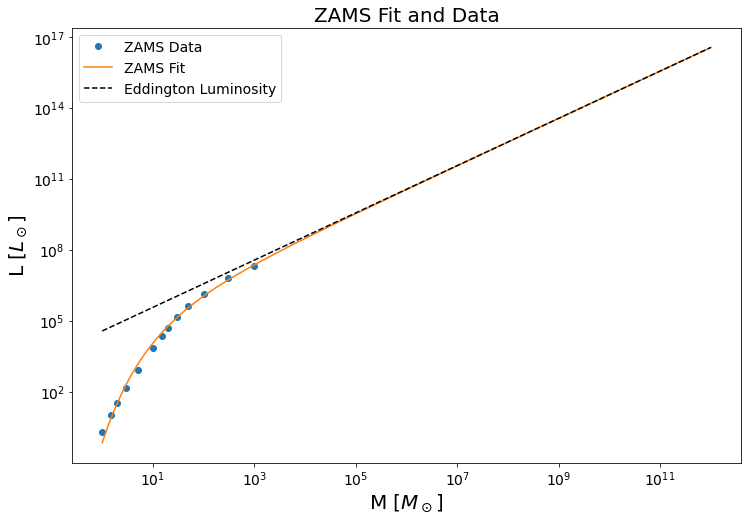

In [5]:
#constants
Lsun       = 3.846e33
LeddFactor = 3.7142e4

#load the data
L = np.power(10,[0.2825, 1.0227, 1.5177, 2.1654, 2.9274, 3.8618, 4.3647, 4.7082, 5.1619, 5.6283, 6.1470, 6.8172, 7.3047])
M = [1, 1.5, 2, 3, 5, 10, 15, 20, 30, 50, 100, 300, 1000]

#load the fit
Msun  = np.logspace(0,12,100)
Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Msun)-1.9551))))
Lfit2 = (Msun**(2.0135/Msun**(0.4817)+1))
Lfit  = (Lfit1*Lfit2)/Lsun

#calculate eddington luminosity
Ledd = Msun*LeddFactor;

fig = plt.figure(figsize = (12,8))
plt.loglog(M,L, 'o', label = 'ZAMS Data')
plt.loglog(Msun, Lfit, '-', label = 'ZAMS Fit')
plt.loglog(Msun, Ledd, color = 'black', ls = '--', label = 'Eddington Luminosity')
plt.xlabel('M [$M_\odot$]', fontsize = 20)
plt.ylabel('L [$L_\odot$]', fontsize = 20)
plt.tick_params(labelsize = 14)
plt.legend(fontsize = 14)
plt.title('ZAMS Fit and Data', fontsize = 20)
plt.savefig('zamsfit.png', dpi = 200)
plt.show()

# Define $C_N$ function and Capture Rate Function

This section is heavily commented so it should be clear. I am defining two functions $\texttt{CaptureN}$ and $\texttt{CaptureRate}$ which take various inputs. $\texttt{CaptureN}$ calculates the capture rate after exactly N scatters, and $\texttt{CaptureRate}$ sums the output of $\texttt{CaptureN}$. Try to identify the inputs of the two functions and how they compare Ilie, Zhang 2019. 

NOTE: The boolean input approx decides whether or not to calculate the approximate $C_{tot}$ (True) or the fully analytical $C_{tot}$ (false).

In [2]:
def CaptureN(M, R, Mchi, approx):
        # define some constants
    G         = 6.6743*10**(-8)                      # gravitational constant in cgs units
    R         = (6.96e10)*R                          # convert radius to centimeters
    M         = 1.9885*(10**33)*M                    # convert mass to grams
    mn        = 0.93827                              # mass of nucleons (protons) in star in GeV 
    Vesc      = np.sqrt(2*G*M/R)                     # escape velocity(cm/s)
    N         = 1                                    # +1 of collision before capture              
    rho_chi   = 10**9;                               # ambient density of dark matter
    nchi      = rho_chi/Mchi                         # number density(cm^{-3})
    vbar      = 10**6                                # DM dispersion velocity in DM halo(cm/s)
    p_hyd     = 0.753                                # percent of mass of sun that is hydrogen
    mn_grams  = 1.6726*10**(-24)                     # mass of nucleon in grams
    sigma_sat = ((np.pi)*(R**2))/(p_hyd*M/(mn_grams))# sigma_sat from bramante+2017
    sigma     = (1.26*10**(-40))*(Mchi/(10**8))      # DM cross section
    
        # initialize series
    Cn = []
    Cn.append(1)
    
    while Cn[N-1] >= 1:
            # increase N by 1
        N     += 1
            # caluclate A_N^2
        An2    = (3*(N-1)*(Vesc**2)*(mn))/((vbar**2)*(Mchi))
            #equation for tau just above equation 15 in Bramante+2017
        tau    = (3/2)*(sigma/sigma_sat)
            # calculate pn(tau)
        pn_tau = (2/tau**2)*N*gammainc(N+1,tau)
            # calculate beta
        beta   = (4*(Mchi)*mn)/((Mchi+mn)**2)
            # calculate V_N
        VN     = Vesc*(1-((beta)/2))**((-1*(N))/2)
            # calculate Cn
        if approx:
            Cn.append(np.sqrt(24*np.pi)*pn_tau*G*nchi*M*R*(1/vbar)*(1-(1+((2*(N-1)*mn)/(Mchi)))*np.exp(-An2)))
        else:
            Cn.append(np.pi*(R**2)*pn_tau*((np.sqrt(2)*nchi)/(np.sqrt(3*np.pi)*vbar))*((((2*vbar**2)+(3*Vesc**2))-((2*vbar**2)+(3*VN**2))*(np.exp(-1*((3*((VN**2)-(Vesc**2)))/(2*(vbar**2))))))))
        
    h, t = 1, 1
    Cn   = np.array(Cn[h:len(Cn)-t])
    return Cn

def CaptureRate(C):
        # get length of C vector
    l     = len(C)
    
        # initialize the series and outputs
    Cn = []
    Cn.append(C[0])
    Nc    = 1
    T     = C[0]
    
        # run for loop to add up all terms in vector C
    for i in range(1,l):
        Cn.append((Cn[i-1] + C[i])) # sum up C_Ns
        T    += C[i]*i #find the average number of scatter before capture        
            
            # cutoff condition
        if ((abs(Cn[i-1]/Cn[i]-1) > 0.001) & (Cn[i]>=Cn[i-1])):
            Nc = i
            
    Ctot = Cn[-1]
    Ne   = T/sum(C)
    return [Ne, Nc, Ctot]

# Test $C_N$ function

This block of code implements the $\texttt{CaptureN}$ function and plots the output of $C_N$ vs. $N$ for a range of dark matter masses.

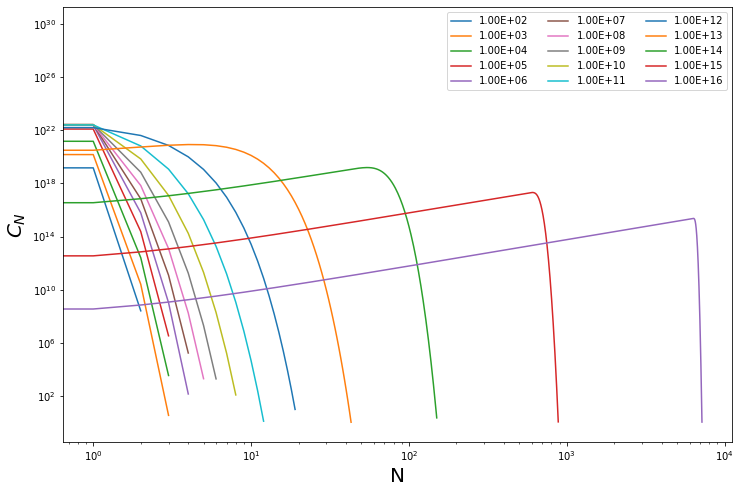

In [4]:
M    = 12
R    = 1.43
mchi = np.logspace(2,16,15)
Cn   = []
for i in range(len(mchi)):
    Cn.append(CaptureN(M,R,mchi[i], True))
    
fig = plt.figure(figsize = (12,8))
for i in range(len(mchi)):
    plt.plot(Cn[i], label = str('%.2E' % mchi[i]))
    plt.legend(loc="upper right",        # Position of the legend
               ncol = 3)         # Add little spacing around the legend box)
    plt.xlabel('N', fontsize = 20)
    plt.ylabel('$C_N$', fontsize = 20)
    plt.xscale('log')
    plt.yscale('log')
plt.savefig('CN_N.png')

# Test Capture Rate function

This block of code implements $\texttt{CaptureRate}$ to plot $C_{tot}$ vs. $m_\chi$ for four example stars. The M, R data is from the ZAMS section above. 

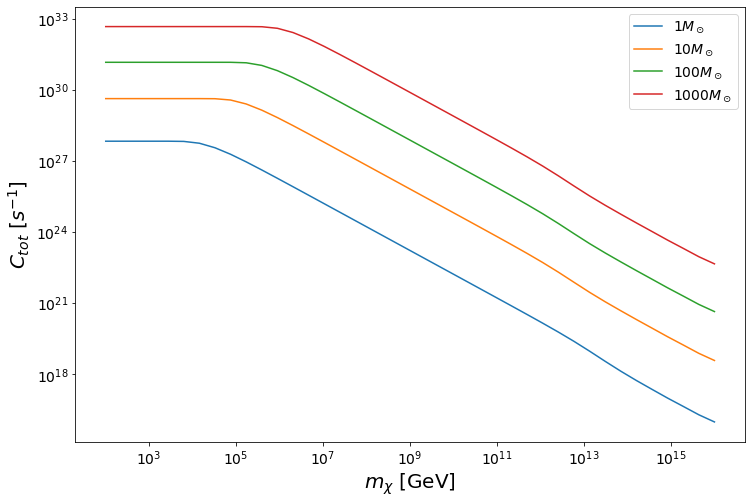

In [3]:
M = [1, 10, 100, 1000]
R  = np.power(10,[-0.0581, 0.1462, 0.6147, 1.1090])
mchi = np.logspace(2,16,40)

    # initialize outputs
Ne = []
Nc = []

fig = plt.figure(figsize = (12,8))

for i in range(len(M)):
    Ctot = []
    for j in range(len(mchi)):
        Ctot.append(CaptureRate(CaptureN(M[i],R[i],mchi[j],False))[2])
    plt.loglog(mchi, Ctot, label = str(M[i]) + '$M_\odot$')
    plt.legend(fontsize = 14,
               loc="upper right")
    
plt.xlabel('$m_\chi$ [GeV]', fontsize = 20)
plt.ylabel('$C_{tot}$ [$s^{-1}$]', fontsize = 20)
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.savefig('Ctot_mchi.png')

# Dark Matter Luminosity Function Defintion

Here, I am defining a function to calculate the dark matter luminosity $L_{DM}$ as a function of $m_\chi$ for various stars. There is an additional boolean input $\texttt{plot}$ to decide whether or not you want to plot the output. 

In [4]:
def LDMfn(M,R,mchi,approx,plot = False):
    #input: array of star masses, star radii, mchi range, and bool(plot) to generate plot
    #plot is in L_sun units, !plot is in erg/s
    if plot:
        fig = plt.figure(figsize = (12,8))
    for i in range(len(M)):
        LDM = []
        for j in range(len(mchi)):
            if plot:
                Lsun = 3.846e33
                LDM.append(((2/3)*mchi[j]*(1/624.15)*CaptureRate(CaptureN(M[i],R[i],mchi[j],approx))[2])/Lsun)
            else: 
                LDM.append(((2/3)*mchi[j]*(1/624.15)*CaptureRate(CaptureN(M[i],R[i],mchi[j],approx))[2]))
        if plot:
            plt.loglog(mchi, LDM, label = str(M[i]) + '$M_\odot$')
            plt.xlabel('$m_\chi$ [GeV]', fontsize = 20)
            plt.ylabel('$L_{DM}$ [$L_\odot$]', fontsize = 20)
            plt.savefig('LDM_mchi.png')
            plt.legend(fontsize = 14,
                       loc="upper left")
            
    return LDM

# Testing LDM Function
Here, I am just implementing the LDM function.

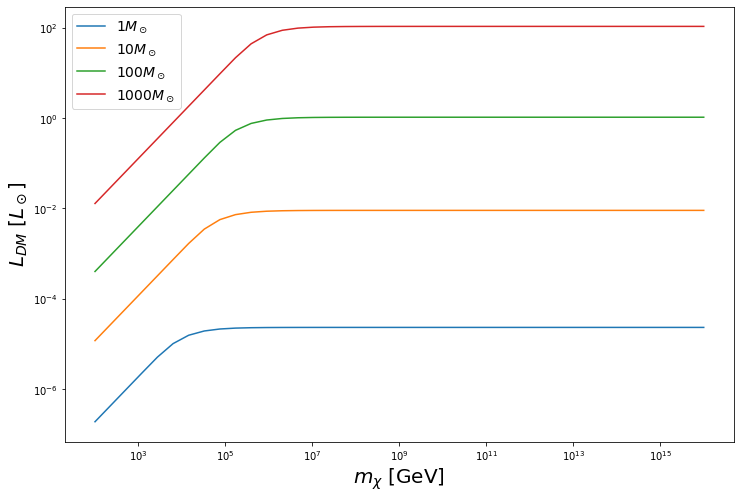

In [7]:
M = [1, 10, 100, 1000]
R  = np.power(10,[-0.0581, 0.1462, 0.6147, 1.1090])
mchi = np.logspace(2,16,40)

LDM = LDMfn(M,R,mchi, True, True)

# Dark Matter Luminosity $10^2$ GeV DM

Here, I calculate the dark matter luminosity for $10^2$ GeV dark matter as a function of the star mass. It's a tricky calculation and uses pretty much all the stuff from above.

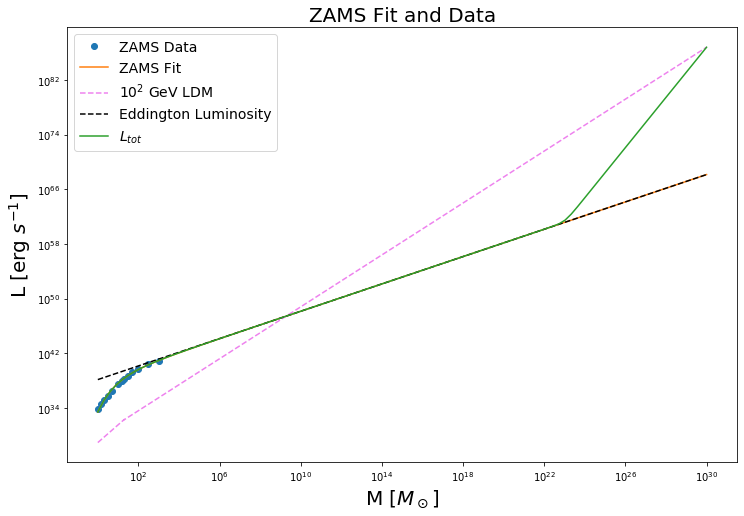

In [19]:
# zams fit
#constants
Lsun       = 3.846e33;
LeddFactor = 3.7142e4;

#load the data
L = Lsun*np.power(10,[0.2825, 1.0227, 1.5177, 2.1654, 2.9274, 3.8618, 4.3647, 4.7082, 5.1619, 5.6283, 6.1470, 6.8172, 7.3047])
M = [1, 1.5, 2, 3, 5, 10, 15, 20, 30, 50, 100, 300, 1000]
R = np.power(10,[-0.0581, -0.0203, 0.0108, 0.0487, 0.0911, 0.1462, 0.1803, 0.2183, 0.3270, 0.4570, 0.6147, 0.8697, 1.1090])

#load the fit for ZAMS
Msun  = np.logspace(0,30,100);
Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Msun)-1.9551))));
Lfit2 = (Msun**(2.0135/Msun**(0.4817)+1));
Lfit  = (Lfit1*Lfit2);

#calculate eddington luminosity
Ledd = Lsun*Msun*LeddFactor;

#############
#############
#   DM Luminosity 10^2 GeV
#############
#############
LDM = []
mchi = 1e8

for i in range(len(M)):
    LDM.append(((2/3)*mchi*(1/624.15)*CaptureRate(CaptureN(M[i],R[i],mchi, True))[2]))

    #power law fit LDM ~ M^a*10^b for 1-20M_sun and then 20-->inf M_sun
lowMstar  = np.polyfit(np.log10(M[0:7]),np.log10(LDM[0:7]),1)
highMstar = np.polyfit(np.log10(M[7:-1]),np.log10(LDM[7:-1]),1)
    #eval
lowMsun = np.logspace(0, np.log10(20), 50)
highMsun = np.logspace(np.log10(20), 30, 50)
LDMMsun = np.concatenate([lowMsun, highMsun])
LDMlow = (lowMsun**lowMstar[0])*(10**lowMstar[1])
LDMhigh = (highMsun**highMstar[0])*(10**highMstar[1])
    #get LDM
LDM = np.concatenate([LDMlow,LDMhigh])

Ltot = LDM + Lfit

fig = plt.figure(figsize = (12,8))
plt.loglog(M,L, 'o', label = 'ZAMS Data')
plt.loglog(Msun, Lfit, '-', label = 'ZAMS Fit')
plt.loglog(LDMMsun, LDM, color = 'violet', ls = '--', label = '$10^{2}$ GeV LDM')
plt.loglog(Msun, Ledd, color = 'black', ls = '--', label = 'Eddington Luminosity')
plt.loglog(Msun, Ltot, label = "$L_{tot}$")
plt.xlabel('M [$M_\odot$]', fontsize = 20)
plt.ylabel('L [erg $s^{-1}$]', fontsize = 20)
plt.legend(fontsize = 14)
plt.title('ZAMS Fit and Data', fontsize = 20)
plt.savefig('dm_luminosity.png')
plt.show()

# DM Luminosity Many Masses

Here, I do the same thing as above but for a range of dark matter masses. 

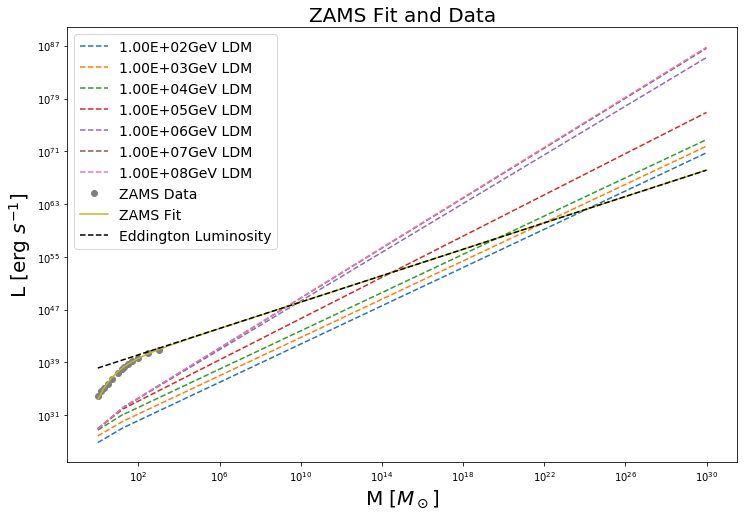

In [17]:
# zams fit
#constants
Lsun       = 3.846e33;
LeddFactor = 3.7142e4;

#load the data
L = Lsun*np.power(10,[0.2825, 1.0227, 1.5177, 2.1654, 2.9274, 3.8618, 4.3647, 4.7082, 5.1619, 5.6283, 6.1470, 6.8172, 7.3047])
M = [1, 1.5, 2, 3, 5, 10, 15, 20, 30, 50, 100, 300, 1000]
R = np.power(10,[-0.0581, -0.0203, 0.0108, 0.0487, 0.0911, 0.1462, 0.1803, 0.2183, 0.3270, 0.4570, 0.6147, 0.8697, 1.1090])

#load the fit for ZAMS
Msun  = np.logspace(0,30,100);
Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Msun)-1.9551))));
Lfit2 = (Msun**(2.0135/Msun**(0.4817)+1));
Lfit  = (Lfit1*Lfit2);

#calculate eddington luminosity
Ledd = Lsun*Msun*LeddFactor;

#############
#############
#   DM Luminosity 10^2 GeV
#############
#############
LDM = []
mchi = np.logspace(2,8,7)
fig = plt.figure(figsize = (12,8))
for j in range(len(mchi)):
    LDM = [0 for i in range(len(M))]
    for i in range(len(M)):
        LDM[i] = (((2/3)*mchi[j]*(1/624.15)))*CaptureRate(CaptureN(M[i],R[i],mchi[j], True))[2]
            #power law fit LDM ~ M^a*10^b for 1-20M_sun and then 20-->inf M_sun
    lowMstar  = np.polyfit(np.log10(M[0:7]),np.log10(LDM[0:7]),1)
    highMstar = np.polyfit(np.log10(M[7:-1]),np.log10(LDM[7:-1]),1)
        #eval
    lowMsun = np.logspace(0, np.log10(20), 50)
    highMsun = np.logspace(np.log10(20), 30, 50)
    LDMMsun = np.concatenate([lowMsun, highMsun])
    LDMlow = (lowMsun**lowMstar[0])*(10**lowMstar[1])
    LDMhigh = (highMsun**highMstar[0])*(10**highMstar[1])
        #get LDM
    LDM = np.concatenate([LDMlow,LDMhigh])
    plt.loglog(LDMMsun, LDM, ls = '--', label = str('%.2E' % mchi[j]) + 'GeV LDM')



    #    plt.plot(Cn[i], label = str('%.2E' % mchi[i]))

    
plt.loglog(M,L, 'o', label = 'ZAMS Data')
plt.loglog(Msun, Lfit, '-', label = 'ZAMS Fit')
plt.loglog(Msun, Ledd, color = 'black', ls = '--', label = 'Eddington Luminosity')
plt.xlabel('M [$M_\odot$]', fontsize = 20)
plt.ylabel('L [erg $s^{-1}$]', fontsize = 20)
plt.legend(fontsize = 14)
plt.title('ZAMS Fit and Data', fontsize = 20)
plt.savefig('dm_luminosity.png')
plt.show()

In [15]:
lowMsun = np.logspace(0, np.log10(20), 50)
highMsun = np.logspace(np.log10(20), 30, 50)
LDMMsun = np.concatenate([lowMsun, highMsun])
len(LDMMsun)
Msun  = np.logspace(0,30,100);
len(Msun)

100

# Try to Animate it

I wanted to animate the plot above, so this cell simply animates the above plot and saves a .gif. It takes awhile to run.

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


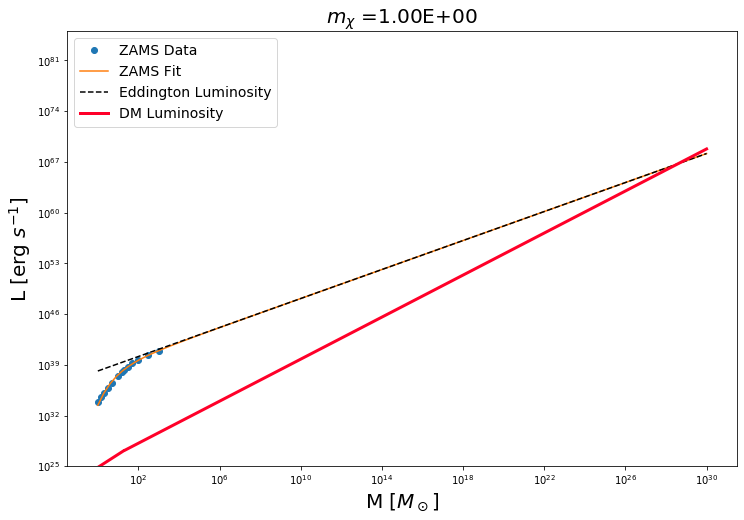

In [8]:
# zams fit
#constants
Lsun       = 3.846e33;
LeddFactor = 3.7142e4;

#load the data
L = Lsun*np.power(10,[0.2825, 1.0227, 1.5177, 2.1654, 2.9274, 3.8618, 4.3647, 4.7082, 5.1619, 5.6283, 6.1470, 6.8172, 7.3047])
M = [1, 1.5, 2, 3, 5, 10, 15, 20, 30, 50, 100, 300, 1000]
R = np.power(10,[-0.0581, -0.0203, 0.0108, 0.0487, 0.0911, 0.1462, 0.1803, 0.2183, 0.3270, 0.4570, 0.6147, 0.8697, 1.1090])

#load the fit for ZAMS
Msun  = np.logspace(0,30,101);
Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Msun)-1.9551))));
Lfit2 = (Msun**(2.0135/Msun**(0.4817)+1));
Lfit  = (Lfit1*Lfit2);

#calculate eddington luminosity
Ledd = Lsun*Msun*LeddFactor;

LDM = []
mchi = np.logspace(0,15,100)
rev = mchi[::-1]
mchi = np.concatenate([mchi, rev])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
plasma = cm.get_cmap('gist_rainbow', len(mchi))
plasmarev = cm.get_cmap('gist_rainbow_r', len(mchi))
    
def updateData(curr):
    LDM = [0 for i in range(len(M))]
    for i in range(len(M)):
        LDM[i] = (((2/3)*mchi[curr]*(1/624.15)))*CaptureRate(CaptureN(M[i],R[i],mchi[curr], True))[2]
            #power law fit LDM ~ M^a*10^b for 1-20M_sun and then 20-->inf M_sun
    lowMstar  = np.polyfit(np.log10(M[0:7]),np.log10(LDM[0:7]),1)
    highMstar = np.polyfit(np.log10(M[7:-1]),np.log10(LDM[7:-1]),1)
        #eval
    lowMsun = np.logspace(0, np.log10(20), 50)
    highMsun = np.logspace(np.log10(20), 30, 50)
    LDMMsun = np.concatenate([lowMsun, highMsun])
    LDMlow = (lowMsun**lowMstar[0])*(10**lowMstar[1])
    LDMhigh = (highMsun**highMstar[0])*(10**highMstar[1])
        #get LDM
    LDM = np.concatenate([LDMlow,LDMhigh])
    ax.clear()
    ax.set_ylim([1e25, 1e85])
    ax.loglog(M,L, 'o', label = 'ZAMS Data')
    ax.loglog(Msun, Lfit, '-', label = 'ZAMS Fit')
    ax.loglog(Msun, Ledd, color = 'black', ls = '--', label = 'Eddington Luminosity')
    plt.xlabel('M [$M_\odot$]', fontsize = 20)
    plt.ylabel('L [erg $s^{-1}$]', fontsize = 20)
    plt.title('$m_\chi$ =' + str('%.2E' % mchi[curr]), fontsize = 20)
    if curr <= 100:
        ax.loglog(LDMMsun, LDM, ls = '-', linewidth = 3, label = 'DM Luminosity', color = plasma(curr))
    else:
        ax.loglog(LDMMsun, LDM, ls = '-', linewidth = 3, label = 'DM Luminosity', color = plasmarev(curr))
    plt.legend(loc = "upper left", fontsize = 14)


simulation = animation.FuncAnimation(fig, updateData, frames = len(mchi), interval=40, repeat=True)
simulation.save('DMluminosity.gif')


# Find maximum masses testing

Need to calculate $L_{DM}$, $L_{edd}$ and $L_{zams}$ for various stellar masses and solve for weak and strong bound. Idea is to find zeros of a spline fit to the data

In [186]:
    #L_zams
Lsun       = 3.846e33;
LeddFactor = 3.7142e4;

#load the data
L = Lsun*np.power(10,[0.2825, 1.0227, 1.5177, 2.1654, 2.9274, 3.8618, 4.3647, 4.7082, 5.1619, 5.6283, 6.1470, 6.8172, 7.3047])
M = [1, 1.5, 2, 3, 5, 10, 15, 20, 30, 50, 100, 300, 1000]
R = np.power(10,[-0.0581, -0.0203, 0.0108, 0.0487, 0.0911, 0.1462, 0.1803, 0.2183, 0.3270, 0.4570, 0.6147, 0.8697, 1.1090])

Msun  = np.logspace(0,30,20000);
Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Msun)-1.9551))));
Lfit2 = (Msun**(2.0135/Msun**(0.4817)+1));
Lfit  = (Lfit1*Lfit2);

    #Ledd
Ledd = Lsun*Msun*LeddFactor;

    #LDM
LDM = []
mchi = 1e2

    for i in range(len(M)):
        LDM.append(((2/3)*mchi*(1/624.15)*CaptureRate(CaptureN(M[i],R[i],mchi, True))[2]))

    #power law fit LDM ~ M^a*10^b for 1-20M_sun and then 20-->inf M_sun
lowMstar  = np.polyfit(np.log10(M[0:7]),np.log10(LDM[0:7]),1)
highMstar = np.polyfit(np.log10(M[7:-1]),np.log10(LDM[7:-1]),1)
    #eval
lowMsun = np.logspace(0, np.log10(20), 10000)
highMsun = np.logspace(np.log10(20), 30, 10000)
LDMMsun = np.concatenate([lowMsun, highMsun])
LDMlow = (lowMsun**lowMstar[0])*(10**lowMstar[1])
LDMhigh = (highMsun**highMstar[0])*(10**highMstar[1])
LDM = np.concatenate([LDMlow,LDMhigh])
    
    #Ltot
Ltot = LDM + Lfit
Ldiff = Ledd - Ltot

#linear interpolation of Ledd - Ltot --> find where that equals 0
Minterp = np.logspace(2,26,10000)
Linterp = np.interp(Mnew,Msun,Ldiff)

neg = np.where(Linterp < 0)[0]
idx_neg = neg[0]
idx_pos = idx_neg-1
    #get those masses, take average
Mmax = (Minterp[int(idx_neg)] + Minterp[int(idx_pos)])/2


IndexError: index 0 is out of bounds for axis 0 with size 0

# Now try to sweep over density and mass parameter space

In [62]:
mchi = np.logspace(2,8,10)
rhochi = np.logspace(9,18,10)
Mmax = np.zeros((len(mchi),len(rhochi)))
fig = plt.figure(figsize = (12,8))
for i in range(len(mchi)):
    
    #L_zams
    Lsun       = 3.846e33;
    LeddFactor = 3.7142e4;

    #load the data
    L = Lsun*np.power(10,[0.2825, 1.0227, 1.5177, 2.1654, 2.9274, 3.8618, 4.3647, 4.7082, 5.1619, 5.6283, 6.1470, 6.8172, 7.3047])
    M = [1, 1.5, 2, 3, 5, 10, 15, 20, 30, 50, 100, 300, 1000]
    R = np.power(10,[-0.0581, -0.0203, 0.0108, 0.0487, 0.0911, 0.1462, 0.1803, 0.2183, 0.3270, 0.4570, 0.6147, 0.8697, 1.1090])

    Msun  = np.logspace(0,30,10000);
    Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Msun)-1.9551))));
    Lfit2 = (Msun**(2.0135/Msun**(0.4817)+1));
    Lfit  = (Lfit1*Lfit2);

        #Ledd
    Ledd = Lsun*Msun*LeddFactor;

        #LDM
    LDM = []

    for j in range(len(M)):
        LDM.append(((2/3)*mchi[i]*(1/624.15)*CaptureRate(CaptureN(M[j],R[j],mchi[i], True))[2]))

        #power law fit LDM ~ M^a*10^b for 1-20M_sun and then 20-->inf M_sun
    lowMstar  = np.polyfit(np.log10(M[0:7]),np.log10(LDM[0:7]),1)
    highMstar = np.polyfit(np.log10(M[7:-1]),np.log10(LDM[7:-1]),1)
        #eval
    lowMsun = np.logspace(0, np.log10(20), 10000)
    highMsun = np.logspace(np.log10(20), 30, 10000)
    LDMMsun = np.concatenate([lowMsun, highMsun])

    for j in range(len(rhochi)):
            #Ltot
        LDMlow = (lowMsun**lowMstar[0])*(10**lowMstar[1])
        LDMhigh = (highMsun**highMstar[0])*(10**highMstar[1])
        if rhochi[j] > 10000000:
            Ltot = rhochi[j]*LDMlow + Lfit
        else:
            Ltot = rhochi[j]*LDMhigh + Lfit
        Ldiff = Ledd - Ltot

        #linear interpolation of Ledd - Ltot --> find where that equals 0
        Minterp = np.logspace(0,30,10000)
        Linterp = np.interp(Minterp,Msun,Ldiff)
        neg = np.where(Linterp < 0)[0]
        idx_neg = neg[0]
        idx_pos = idx_neg-1
            #get those masses, take average
        Mmax[i][j] = (Minterp[int(idx_neg)] + Minterp[int(idx_pos)])/2




IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 864x576 with 0 Axes>

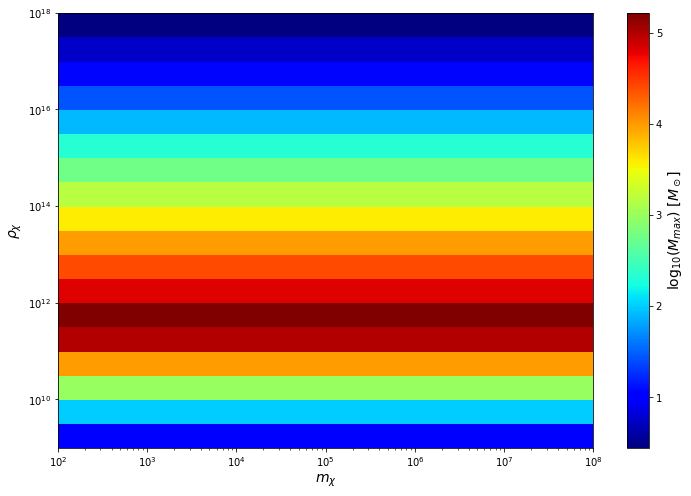

In [146]:
mxmx, rhorho = np.meshgrid(mchi,rhochi)

fig = plt.figure(figsize = (12,8))
plt.pcolormesh(mxmx,rhorho,np.transpose(np.log10(Mmax_out)), cmap = 'jet')
cbar = plt.colorbar()
cbar.set_label('$\log_{10}(M_{max})$ [$M_\odot$]',fontsize = 14)
plt.xlabel('$m_\chi$',fontsize = 14)
plt.ylabel('$\\rho_\chi$', fontsize = 14)
plt.xscale('log')
plt.yscale('log')


In [145]:
mchi = np.logspace(2,8,19)
rhochi = np.logspace(9,18,19)
Mmax = np.zeros((len(mchi)))
Mmax_out = []
for i in range(len(mchi)):
    
    #L_zams
    Lsun       = 3.846e33;
    LeddFactor = 3.7142e4;

    #load the data
    L = Lsun*np.power(10,[0.2825, 1.0227, 1.5177, 2.1654, 2.9274, 3.8618, 4.3647, 4.7082, 5.1619, 5.6283, 6.1470, 6.8172, 7.3047])
    M = [1, 1.5, 2, 3, 5, 10, 15, 20, 30, 50, 100, 300, 1000]
    R = np.power(10,[-0.0581, -0.0203, 0.0108, 0.0487, 0.0911, 0.1462, 0.1803, 0.2183, 0.3270, 0.4570, 0.6147, 0.8697, 1.1090])

    Msun  = np.logspace(0,30,10000);
    Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Msun)-1.9551))));
    Lfit2 = (Msun**(2.0135/Msun**(0.4817)+1));
    Lfit  = (Lfit1*Lfit2);

        #Ledd
    Ledd = Lsun*Msun*LeddFactor;

        #LDM
    LDM = []

    for j in range(len(M)):
        LDM.append(((2/3)*mchi[i]*(1/624.15)*CaptureRate(CaptureN(M[j],R[j],mchi[i], True))[2]))

        #power law fit LDM ~ M^a*10^b for 1-20M_sun and then 20-->inf M_sun
    lowMstar  = np.polyfit(np.log10(M[0:7]),np.log10(LDM[0:7]),1)
    highMstar = np.polyfit(np.log10(M[7:-1]),np.log10(LDM[7:-1]),1)
        #eval
    lowMsun = np.logspace(0, np.log10(20), 10000)
    highMsun = np.logspace(np.log10(20), 30, 10000)
    LDMMsun = np.concatenate([lowMsun, highMsun])
    LDMlow = (lowMsun**lowMstar[0])*(10**lowMstar[1])
    LDMhigh = (highMsun**highMstar[0])*(10**highMstar[1])
    
    for j in range(1,16):
        f = lambda Mstar: 10**((j-1)/2)*Mstar**(highMstar[0])*10**(highMstar[1]) + (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Mstar)-1.9551))))*(Mstar**(2.0135/Mstar**(0.4817)+1)) - Mstar*Lsun*LeddFactor
        Mmax[j-1] = fsolve(f,10**j)
    for j in range(16,20):
        f = lambda Mstar: 10**((j-1)/2)*Mstar**(lowMstar[0])*10**(lowMstar[1]) + (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(Mstar)-1.9551))))*(Mstar**(2.0135/Mstar**(0.4817)+1)) - Mstar*Lsun*LeddFactor
        Mmax[j-1] = fsolve(f,10**j)
    Mmax_out.append(Mmax)


/Users/jacobpilawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in power
/Users/jacobpilawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10


# June 7 2020

In [3]:
def bounds(mchi,rhochi,M,R):

    mchi = mchi

    # Constants
    Msun = 1.9885*10**33
    Rsun = 69.634*10**9
    mn = 0.939
    c = 3*10**10
    G = 6.6743*10**(-8)
    rhochi = rhochi
    vbar = 10**6
    Lsun       = 3.846*10**33
    LeddFactor = 3.7142*10**4
    nchi = rhochi/mchi; 
    f = 2/3

    # Star
    M = M
    R = R
        #stuff you calculate for star
    Vesc = np.sqrt(2*G*(M*Msun)/(R*Rsun))

    # Luminosity Calculations
        #Lnuclear
    Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(M)-1.9551))))
    Lfit2 = (M**(2.0135/M**(0.4817)+1))
    Lnuc  = (Lfit1*Lfit2)

        #calculate eddington luminosity
    Ledd = M*LeddFactor*Lsun

    # Define right hand side
    rhs = ((Ledd - Lnuc)/(f*np.sqrt(24*np.pi)*G*(M*Msun)*(R*Rsun)*(1/vbar)))*(1/rhochi)

    # Solve for \sigma
    tau = [0 for i in range(len(mchi))]
    sigmaBound = [0 for i in range(len(mchi))]
    An2 = [0 for i in range(len(mchi))]

    for i in range(len(mchi)):
        sigmalow = 10**(-60);              
        sigmaup = 10**(-30);               

        while (np.log10(sigmaup) - np.log10(sigmalow) >= 0.00001):
            sigma = 10**((np.log10(sigmaup)+np.log10(sigmalow))/2)
            tau[i] = 3/2*(M*Msun)/(1.6726*10**(-24))*sigma/np.pi/(R*Rsun)**2
            lhs = 0              

            if (tau[i] <= 1):
                An2[i] = 3*Vesc**2*0.93827/(vbar**2)/mchi[i]
                lhs = (1-(1+2*0.93827/mchi[i])*np.exp(-An2[i]))*(2/tau[i]**2)*2*gammainc(3,tau[i])
            else:
                k = 1
                while (k <= 2*tau[i]+2):
                    An2[i] = 3*Vesc**2*k*0.93827/(vbar**2)/mchi[i]
                    lhs = lhs + (1-(1+2*k*0.93827/mchi[i])*np.exp(-An2[i]))*2/tau[i]**2*(k+1)*gammainc(k+2, tau[i])
                    k += 1
            if (lhs >= rhs):
                sigmaup = sigma      
            else:
                sigmalow = sigma
        sigmaBound[i] = sigma
    return sigmaBound

In [108]:
# # xenon data
# mx = np.linspace(2,15,40)
# XENON = 10**(0.99823116*mx-49.68264486)
# mx = 10**mx

# plt.figure(figsize = (12,8))
# plt.loglog(mchi,sigmanxmulticrit, label = '10 M$_\odot$')
# plt.fill_between(mx, XENON, 1e-34,
#                  facecolor="gray", 
#                  color='black',       
#                  alpha=0.2,
#                  label = 'X1T Neutrino Floor')          
# plt.xlabel('m$_\chi$ [GeV]', fontsize = 16)
# plt.ylabel('$\sigma$ [cm$^{2}$]', fontsize = 16)
# plt.tick_params(axis="x", labelsize=14)
# plt.tick_params(axis="y", labelsize=14)
# plt.legend(loc = 'upper left', fontsize = 16)
# plt.xlim([1e2,1e15])
# plt.ylim([1e-55, 1e-35])
# plt.show()

In [4]:
mchi = np.logspace(2,15,150)
rhochi = np.array([10**18, 10**19, 10**20, 10**21, 10**22,10**23])
M = 10
R = 10**0.1462

sigmaBounds = np.zeros((6, 150))

for i in range(len(rhochi)):
    sigmaBounds[i,:] = bounds(mchi,rhochi[i],M,R)

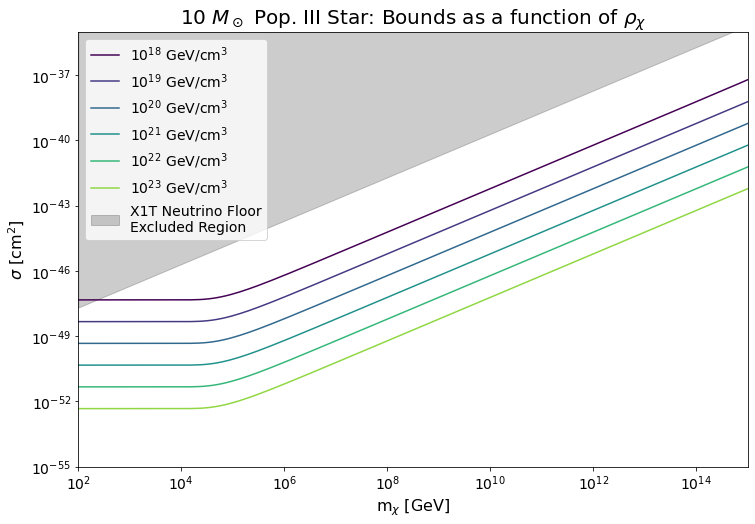

In [5]:
    # xenon data
mx = np.linspace(2,15,40)
XENON = 10**(0.99823116*mx-49.68264486)
mx = 10**mx

palette = plt.get_cmap('viridis')
legend = ['$10^{18}$ GeV/cm$^{3}$','$10^{19}$ GeV/cm$^{3}$','$10^{20}$ GeV/cm$^{3}$','$10^{21}$ GeV/cm$^{3}$','$10^{22}$ GeV/cm$^{3}$','$10^{23}$ GeV/cm$^{3}$']

plt.figure(figsize = (12,8))
plt.fill_between(mx, XENON, 1e-34, 
                 facecolor="gray", 
                 color='black', 
                 alpha=0.2,
                 label = 'X1T Neutrino Floor\nExcluded Region')

    for i in range(len(rhochi)):
        plt.loglog(mchi,sigmaBounds[i,:], color = palette(i/6), label = legend[i])
          
plt.xlabel('m$_\chi$ [GeV]', fontsize = 16)
plt.ylabel('$\sigma$ [cm$^{2}$]', fontsize = 16)
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim([1e2,1e15])
plt.ylim([1e-55, 1e-35])
plt.title('10 $M_\odot$ Pop. III Star: Bounds as a function of $\\rho_\chi$', fontsize = 20)
#plt.savefig('bounds_prelim.png', dpi = 250)
plt.show()

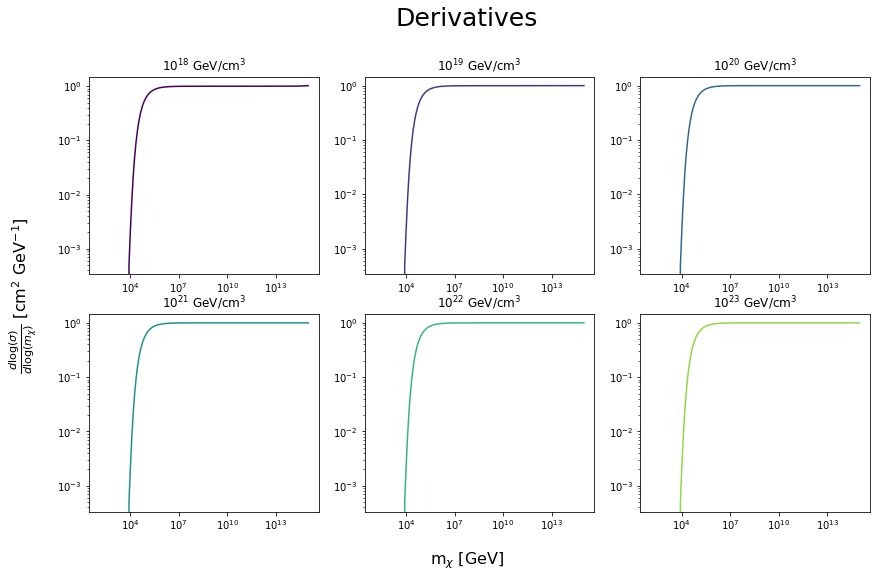

In [6]:
    #derivatives
dsigmadm = np.diff(np.log10(sigmaBounds))/np.diff(np.log10(mchi))
mchi_trim = mchi[1:len(mchi)]
palette = plt.get_cmap('viridis')
title = ['$10^{18}$ GeV/cm$^{3}$','$10^{19}$ GeV/cm$^{3}$','$10^{20}$ GeV/cm$^{3}$','$10^{21}$ GeV/cm$^{3}$','$10^{22}$ GeV/cm$^{3}$','$10^{23}$ GeV/cm$^{3}$']


fig = plt.figure(figsize = (14,8))
    for i in range(len(rhochi)):
        plt.subplot(2,3,i+1)
        plt.loglog(mchi_trim, dsigmadm[i,:], color = palette(i/6))
        plt.title(title[i])
    
fig.text(0.5, 0.04, 'm$_\chi$ [GeV]', ha='center', va='center', 
         fontsize = 16)
fig.text(0.5, 0.98, 'Derivatives', ha='center', va='center', 
         fontsize = 25)
fig.text(0.06, 0.5, '$\\frac{d \log{(\sigma)}}{d \log{(m_\chi)}}$ [cm$^{2}$ GeV$^{-1}$]', ha='center', va='center', 
         rotation='vertical', fontsize = 16)
#plt.savefig('derivatives_prelim.png', dpi = 300)
plt.show()

# Constraint Plots

In [1]:
#mass radius homology function
# take in M in solar mass, get out R in solar radii
def radius(M):
    if (M < 20):
        R = (10**(-0.05446826122331766))*M**(0.2052003119663239)
    elif (M == 20):
        R = ((10**(-0.05446826122331766))*M**(0.2052003119663239) + (10**(-0.4878041731674357))*M**(0.5500991134252413))/2
    elif (M > 20):
        R = (10**(-0.4878041731674357))*M**(0.5500991134252413)
    return R

In [2]:
def rhs(mchi,rhochi,M):

    # Constants
    Msun = 1.9885*10**33
    Rsun = 69.634*10**9
    mn = 0.939
    c = 3*10**10
    G = 6.6743*10**(-8)
    rhochi = rhochi
    vbar = 10**6
    Lsun       = 3.846*10**33
    LeddFactor = 3.7142*10**4
    nchi = rhochi/mchi; 
    f = 2/3

    # Star
    M = M
    R = radius(M)
        #stuff you calculate for star
    Vesc = np.sqrt(2*G*(M*Msun)/(R*Rsun))

    # Luminosity Calculations
        #Lnuclear
    Lfit1 = (10**(np.log10(LeddFactor*Lsun)/(1+np.exp(-0.8502*np.log10(M)-1.9551))))
    Lfit2 = (M**(2.0135/M**(0.4817)+1))
    Lnuc  = (Lfit1*Lfit2)

        #calculate eddington luminosity
    Ledd = M*LeddFactor*Lsun

    # Define right hand side
    rhs = ((Ledd - Lnuc)/(f*np.sqrt(24*np.pi)*G*(M*Msun)*(R*Rsun)*(1/vbar)))*(1/rhochi)
    return rhs

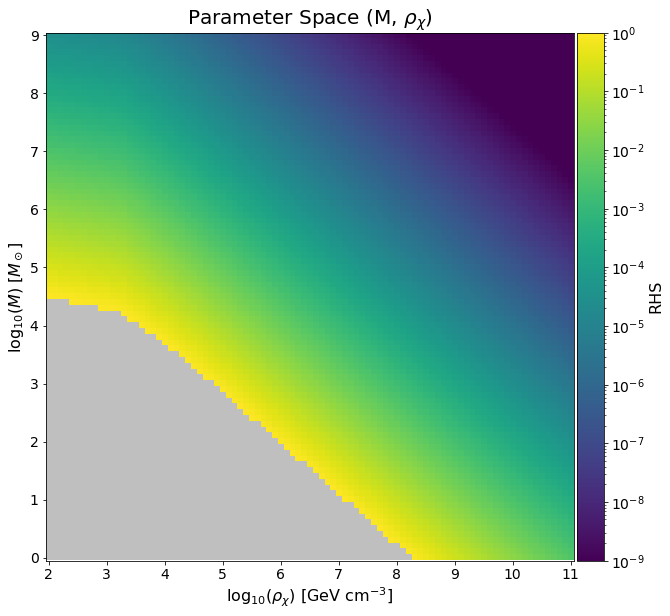

In [16]:
mchi = 1e13
rhochi = np.logspace(2,11,91)
M = np.logspace(0,9,91)
rhochi_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
M_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rhs_ans = [[0 for i in range(len(rhochi))] for i in range(len(M))]

for i in range(len(rhochi)):
    for j in range(len(M)):
        rhs_ans[i][j] = rhs(mchi, rhochi[i], M[j])
        
rhs_ans = np.array(rhs_ans)
rhs_ans[rhs_ans > 1] = float("NaN")
        
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

cmap = plt.get_cmap('viridis')
cmap.set_bad(color = 'grey', alpha = 0.5)
fig, ax = plt.subplots(figsize = (10,10))
im = plt.imshow(rhs_ans, cmap, norm=colors.LogNorm(vmin=0.000000001, vmax=1))
x_label_list = rhochi_list
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_xticklabels(x_label_list)
y_label_list = M_list
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_yticklabels(y_label_list)
plt.xlabel('$\log_{10}\\left(\\rho_\chi\\right)$ [GeV cm$^{-3}$]', fontsize = 16)
plt.ylabel('$\log_{10}\\left(M\\right)~ [M_\odot]$', fontsize = 16)
plt.gca().invert_yaxis()
plt.tick_params(labelsize = 14)
plt.title('Parameter Space (M, $\\rho_\chi$)', fontsize = 20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax, label = 'RHS')
cbar.set_label('RHS', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.show()